In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
# Define path to datasets
DATA_REDUCED = "./MESD_Speaker_embedded_naturalness-reduced_female_voices"
DATA_NATURAL = "./MESD_All"

## GET SAMPLE

In [3]:
SAMPLE_FILE = '/Anger_C_A_abajo.wav'

# load the audio file to get the sample
samples, sample_rate = librosa.load(DATA_NATURAL + SAMPLE_FILE, sr = None)

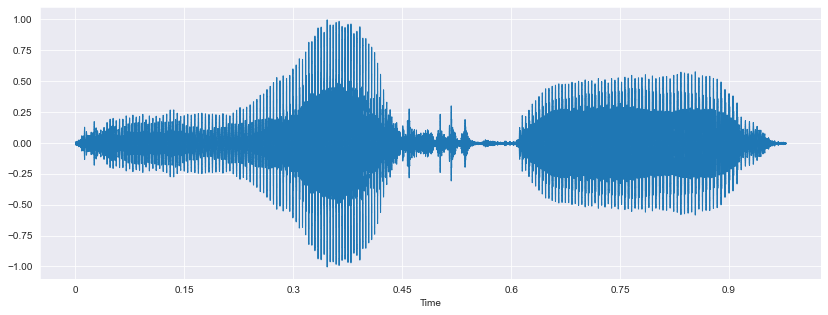

In [4]:
# visualize the sound wave
plt.figure(figsize = (14, 5))
librosa.display.waveshow(samples, sr = sample_rate)

In [6]:
# play the audio directly
Audio(DATA_NATURAL + SAMPLE_FILE)

In [7]:
print ('Sample shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))

Sample shape  (46924,) Sample rate  48000 Data type <class 'numpy.ndarray'>


/Users/helloimrosie/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


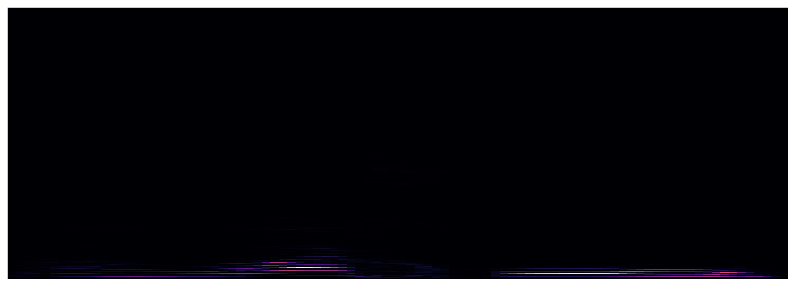

In [8]:
# Spectrograms: plot frequency vs time to indicate the Amplitude of each frequency
plt.figure(figsize = (14, 5))
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

/var/folders/xq/79ls2g8547bdfhql62t94dt00000gn/T/ipykernel_58725/2150084059.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(format='+% dB')


<Figure size 1008x360 with 0 Axes>

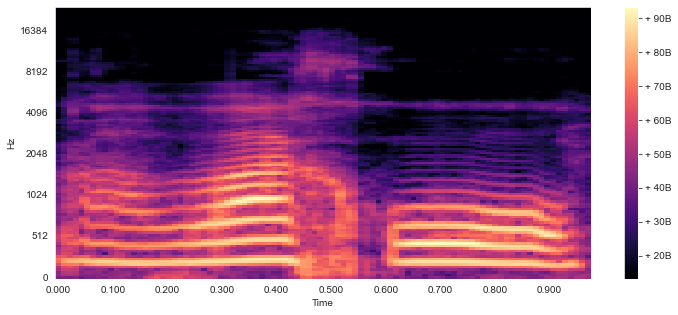

In [9]:
# Modify the to use Mel Scale (a scale of pitches, s.t. each unit is judged by listeners to be equal in pitches distance from the next) instead of Frequency
plt.figure(figsize = (14, 5))
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
# use the decibel scale to get the final Mel Spectrogram
plt.figure(figsize = (12, 5))
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='+% dB')

## OVERALL EXPLORATION

In [11]:
entries = os.listdir(DATA_NATURAL)

In [67]:
dataset = []
for entry in entries:
    entryArr = entry.split("_")
    if len(entryArr) != 4:
        continue
    dataset.append([])
    dataset[-1].append(entry)
    dataset[-1].append(entryArr[0]) # emotion
    dataset[-1].append(entryArr[1]) # gender
    dataset[-1].append(entryArr[3].split(".")[0]) # word

In [68]:
df = pd.DataFrame(dataset, columns=['filename', 'emotion', 'gender', 'word'])

In [52]:
df.head(5)

,filename,emotion,gender,word
0,Anger_C_B_danino.wav,Anger,C,danino
1,Sadness_F_B_explosion.wav,Sadness,F,explosion
2,Disgust_C_B_robo.wav,Disgust,C,robo
3,Neutral_M_B_bola.wav,Neutral,M,bola
4,Happiness_F_B_baile.wav,Happiness,F,baile


In [53]:
num_data = len(df)
num_emotion = len(df['emotion'].unique())
num_gender = len(df['gender'].unique())
num_words = len(df['word'].unique())
print(f'There are total of {num_data} audio pieces.')
print(f'Number of emotions: {num_emotion}')
print(f'Number of genders: {num_gender}')
print(f'Number of words: {num_words}')

There are total of 807 audio pieces.
Number of emotions: 6
Number of genders: 3
Number of words: 201


In [54]:
# gender exploration
df['gender'].value_counts()

F    270
M    270
C    267
Name: gender, dtype: int64

In [55]:
# emotion exploration
df['emotion'].value_counts()

Sadness      135
Disgust      135
Fear         135
Anger        134
Neutral      134
Happiness    134
Name: emotion, dtype: int64

In [71]:
df['audio_len'] = 0
df['sample_rate'] = 0

for i in range(len(df)):
  entry = df.iloc[i,0]
  file_path = DATA_NATURAL +'/'+ entry
  sample, sample_rate = librosa.load(file_path, sr = None)
  df.iloc[i, -2] = len(sample)
  df.iloc[i, -1] = sample_rate

In [77]:
df.head()

,filename,emotion,gender,word,audio_len,sample_rate
0,Anger_C_B_danino.wav,Anger,C,danino,36650,48000
1,Sadness_F_B_explosion.wav,Sadness,F,explosion,38775,48000
2,Disgust_C_B_robo.wav,Disgust,C,robo,31764,48000
3,Neutral_M_B_bola.wav,Neutral,M,bola,17098,48000
4,Happiness_F_B_baile.wav,Happiness,F,baile,25375,48000


In [81]:
min_length = df['audio_len'].min()
max_length = df['audio_len'].max()
print(f'Minimum length of data: {min_length}')
print(f'Maximum length of data: {max_length}')

Minimum length of data: 9554
Maximum length of data: 111922


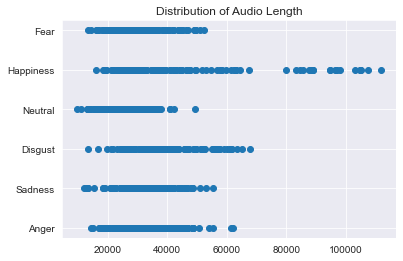

In [78]:
# Audio Length
plt.plot(df['audio_len'], df['emotion'], 'o')
plt.title("Distribution of Audio Length")
plt.show()

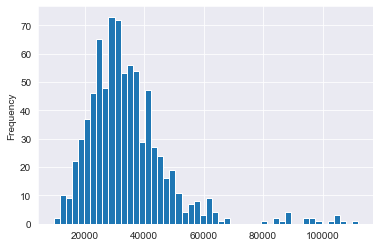

In [79]:
df['audio_len'].plot.hist(bins = 50) #(bins=12, alpha=0.5)
plt.show()

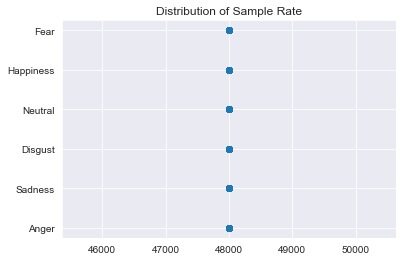

In [80]:
# Sample Rate
plt.plot(df['sample_rate'], df['emotion'], 'o')
plt.title("Distribution of Sample Rate")
plt.show()